In [1]:
from bs4 import BeautifulSoup
import re
import codecs
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import os

In [2]:
output_txt = 'punctuation_output.txt'
total_sites = 28026
path = '../content/'

In [38]:
with tqdm_notebook(total=total_sites) as pbar:
    with open(output_txt, 'w') as out_f:
        out_f.write('{}\t{}\t{}\t{}\t{}\n'.format('doc_id', 'excl_mrk_num', 'ques_mrk_num', \
                                                  'poin_mrk_num', 'ellp_mrk_num'))
        for doc_id in range(1,total_sites+1):
            with open(path + str(doc_id) + ".dat",'r') as in_f:
            
                soup = BeautifulSoup(in_f, 'html.parser')
                excl_mrk_num = len(re.findall(r'[ёЁА-я]+!', soup.text))
                ques_mrk_num = len(re.findall(r'[ёЁА-я]+\?', soup.text))
                poin_mrk_num = len(re.findall(r'[ёЁА-я]+\.', soup.text))
                ellp_mrk_num = len(re.findall(r'[ёЁА-я]+\.\.\.', soup.text))

                out_f.write('{}\t{}\t{}\t{}\t{}\n'.format(doc_id, excl_mrk_num, ques_mrk_num, \
                                                          poin_mrk_num, ellp_mrk_num))
                pbar.update()

In [3]:
df = pd.read_csv(output_txt, sep='\t', encoding='utf-8', lineterminator='\n')
df.head()

,doc_id,excl_mrk_num,ques_mrk_num,poin_mrk_num,ellp_mrk_num
0,1,0,11,202,3
1,2,0,4,34,0
2,3,57,175,2747,86
3,4,4,117,2544,7
4,5,28,9,367,22


In [40]:
df.describe()

,doc_id,excl_mrk_num,ques_mrk_num,poin_mrk_num,ellp_mrk_num
count,28026.000000,28026.000000,28026.000000,28026.000000,28026.000000
mean,14013.500000,44.633269,53.399451,641.717370,21.742989
std,8090.553658,207.963022,203.914824,1794.826849,115.601917
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,7007.250000,1.000000,2.000000,45.000000,0.000000
50%,14013.500000,4.000000,7.000000,106.000000,1.000000
75%,21019.750000,18.000000,23.000000,418.000000,8.000000
max,28026.000000,8676.000000,9191.000000,55464.000000,6262.000000


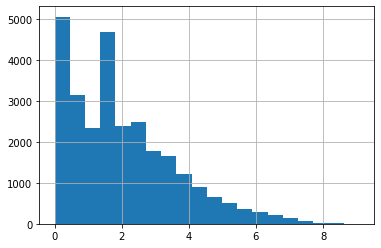

In [56]:
df['log_emn'] = df.excl_mrk_num.apply(lambda x: np.log(1+x))
df.log_emn.hist(bins=20)

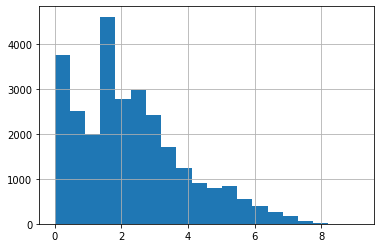

In [59]:
df['log_qmn'] = df.ques_mrk_num.apply(lambda x: np.log(1+x))
df.log_qmn.hist(bins=20)

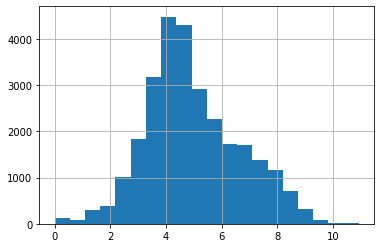

In [60]:
df['log_pmn'] = df.poin_mrk_num.apply(lambda x: np.log(1+x))
df.log_pmn.hist(bins=20)

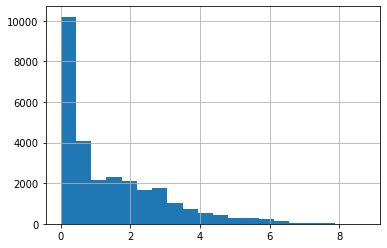

In [61]:
df['log_elmn'] = df.ellp_mrk_num.apply(lambda x: np.log(1+x))
df.log_elmn.hist(bins=20)

In [64]:
df.describe()

,doc_id,excl_mrk_num,ques_mrk_num,poin_mrk_num,ellp_mrk_num,log_emn,log_qmn,log_pmn,log_elmn
count,28026.000000,28026.000000,28026.000000,28026.000000,28026.000000,28026.000000,28026.000000,28026.000000,28026.000000
mean,14013.500000,44.633269,53.399451,641.717370,21.742989,1.982934,2.265659,4.953548,1.345597
std,8090.553658,207.963022,203.914824,1794.826849,115.601917,1.631781,1.664115,1.695680,1.503184
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7007.250000,1.000000,2.000000,45.000000,0.000000,0.693147,1.098612,3.828641,0.000000
50%,14013.500000,4.000000,7.000000,106.000000,1.000000,1.609438,2.079442,4.672829,0.693147
75%,21019.750000,18.000000,23.000000,418.000000,8.000000,2.944439,3.178054,6.037871,2.197225
max,28026.000000,8676.000000,9191.000000,55464.000000,6262.000000,9.068431,9.126089,10.923507,8.742415


In [68]:
df[['doc_id', 'log_emn', 'log_qmn', 'log_pmn', 'log_elmn']].to_csv("punctuation_output_log.txt", \
                                                                   index=False, sep='\t')

In [26]:
df = pd.read_csv('punctuation_output_log.txt', sep='\t', encoding='utf-8', lineterminator='\n')
df.head()

,doc_id,log_emn,log_qmn,log_pmn,log_elmn
0,1,0.000000,2.484907,5.313206,1.386294
1,2,0.000000,1.609438,3.555348,0.000000
2,3,4.060443,5.170484,7.918629,4.465908
3,4,1.609438,4.770685,7.841886,2.079442
4,5,3.367296,2.302585,5.908083,3.135494


In [75]:
def do_features(name, input_file, tr_or_tst_groups):
    feature = pd.read_csv(input_file, sep='\t', encoding='utf-8', lineterminator='\n')
    group_df = pd.read_csv(tr_or_tst_groups, sep=',', encoding='utf-8', lineterminator='\n')
    feature = pd.merge(feature, group_df, on='doc_id', how='right', sort=True).dropna()
    feature['mean_'+name] = feature.groupby('group_id')[name].transform('mean')
    feature = feature[['mean_'+name, 'pair_id',name]]
    feature['pair_id'] = feature['pair_id'].astype(int)    
    feature = pd.merge(group_df, feature, on='pair_id', how='left', sort=True)
    feature['diff_'+name] = np.abs(feature['mean_'+name] - feature[name])

    return feature['diff_'+name].tolist()

name = 'log_emn'
input_file = 'punctuation_output_log.txt'
tr_or_tst_groups = '../train_groups.csv'
do_features(name, input_file, tr_or_tst_groups);

In [29]:
def add_group_id(df):
    group_df = pd.read_csv('../train_groups.csv', sep=',', encoding='utf-8', lineterminator='\n')
    group_df = group_df[['doc_id', 'group_id']]
    group_df.index = group_df.doc_id
    group_df.drop('doc_id', inplace=True, axis=1)
    group_df = group_df.sort_index()
    df = pd.merge(df, group_df, on='pair_id', how='right')

    group_df = pd.read_csv('../test_groups.csv', sep=',', encoding='utf-8', lineterminator='\n')
    group_df = group_df[['doc_id', 'group_id']]
    group_df.index = group_df.doc_id
    group_df.drop('doc_id', inplace=True, axis=1)
    group_df = group_df.sort_index()
    df = pd.merge(df, group_df, on='pair_id', how='right')

    df['group_id'] = df.where(pd.notna(df.group_id_x), df.group_id_y, axis=0).group_id_x.astype(int)
    df.drop(['group_id_x','group_id_y'], inplace=True, axis=1)
    df = df.dropna()
    return df

In [30]:
df = add_group_id(df)
df.head(2)

KeyError: 'pair_id'

In [19]:
df['mean_num_emn'] = df.groupby('group_id')['log_emn'].transform('mean')
df['diff_emn'] = np.abs(df['mean_num_emn'] - df['log_emn'])

In [20]:
df['mean_num_qmn'] = df.groupby('group_id')['log_qmn'].transform('mean')
df['diff_qmn'] = np.abs(df['mean_num_qmn'] - df['log_qmn'])

In [21]:
df['mean_num_pmn'] = df.groupby('group_id')['log_pmn'].transform('mean')
df['diff_pmn'] = np.abs(df['mean_num_pmn'] - df['log_pmn'])

In [22]:
df['mean_num_elmn'] = df.groupby('group_id')['log_elmn'].transform('mean')
df['diff_elmn'] = np.abs(df['mean_num_elmn'] - df['log_elmn'])

In [25]:
df.head(2)

,doc_id,log_emn,log_qmn,log_pmn,log_elmn,group_id,mean_num_emn,diff_emn,mean_num_qmn,diff_qmn,mean_num_pmn,diff_pmn,mean_num_elmn,diff_elmn
0,1,0.0,2.484907,5.313206,1.386294,3,2.343188,2.343188,2.784026,0.299119,6.493965,1.180759,1.713429,0.327135
1,2,0.0,1.609438,3.555348,0.000000,280,2.036708,2.036708,2.387526,0.778088,4.847264,1.291916,1.572007,1.572007


In [24]:
df[['doc_id', 'diff_emn', 'diff_qmn', 'diff_pmn', 'diff_elmn']].to_csv("punctuation_output_log_diff.txt", \
                                                                        index=False, sep='\t')